# Introduction

Trying to see how the correlation histograms change as we increase count thresholds

In [1]:
import numpy
import scanpy
import anndata
import os
import pandas
from matplotlib import pyplot
from matplotlib import cm
import scipy
from pathlib import Path
import upsetplot
import louvain
import sklearn
import seaborn
import logging

from pipeline_common import get_gene_id_to_name, load_gtf
#from cuml.decomposition import PCA
#from cuml.manifold import TSNE


In [2]:
def compute_spearman_pandas(left, right, min_count=0, min_genes=0):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    cells = []
    for c in left.columns:
        lfilter = left[c] >= min_count
        rfilter = right[c] >= min_count
        both = lfilter & rfilter
        if both.sum() > min_genes:
            cors.append(scipy.stats.spearmanr(left[c][both], right[c][both])[0])
            cells.append(c)
    cors = pandas.Series(cors, index=cells)
    #[~numpy.isnan(cors)]
    return cors


In [9]:
def compute_correlations(tables, min_count=0, min_genes=0):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y], min_count=min_count, min_genes=min_genes)
            #assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [23]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)


def plot_cell_correlation_histogram(
    table, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    override_labels = {
        'Alevin': 'Salmon Alevin (EM)',
        'Kallisto EM': 'Kallisto Bus (EM)'
    }
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(table.keys())
    plot_size = len(programs)-1
    cell_hists = {}
    f = pyplot.figure(figsize=(plot_size * 2, plot_size * 2))
    f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)


    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    
    for i in range(0, plot_size):
        for j in range(i+1, plot_size):
            set_all_spines(axes[i, j], False)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            x_label = override_labels.get(name_x, name_x)
            y_label = override_labels.get(name_y, name_y)
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if xlim is not None:
                ax.set_xlim(xlim)
            #set_all_spines(ax, True)
            if x == 0:
                ax.set_ylabel(y_label, fontname=fontname, fontsize=fontsize)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            nantext=""
            if count_nans:
                nantext="\nNaNs {}".format(table[name_x][name_y].isna().sum())
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    for y in range(plot_size):
        x_label = override_labels.get(programs[y], programs[y])
        axes[0, y].set_title(x_label, fontname=fontname, fontsize=fontsize)
        axes[plot_size-1, y].set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    #f.tight_layout()
    
    

In [5]:
analysis_dir = Path('ENCSR874BOF_e10_5_minimal_limb')

In [6]:
cellranger_name = "Cell Ranger"
star_name = "STAR Solo"
alevin_name = "Salmon Alevin (EM)"
alevin_decoy_name = "Salmon Alevin Decoy (EM)"
kallisto_name = "Kallisto"
kallisto_em_name = "Kallisto (EM)"

In [7]:
tenx_datasets = {
    cellranger_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad').to_df().T,
    star_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad').to_df().T,
    alevin_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad').to_df().T,
    alevin_decoy_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin_decoy.h5ad').to_df().T,    
    kallisto_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad').to_df().T,
    kallisto_em_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_em_filtered.h5ad').to_df().T,
}

In [8]:
cor_1_1000 = compute_correlations(tenx_datasets, 1, 1000)


AssertionError: 

In [27]:
cor_2_1000 = compute_correlations(tenx_datasets, 2, 1000)


In [10]:
cor_10_1000 = compute_correlations(tenx_datasets, 10, 1000)
cor_100_1000 = compute_correlations(tenx_datasets, 100, 1000)

In [29]:
cor_100_10 = compute_correlations(tenx_datasets, 100, 10)

In [21]:
plots=[cellranger_name, star_name, alevin_name, kallisto_em_name]

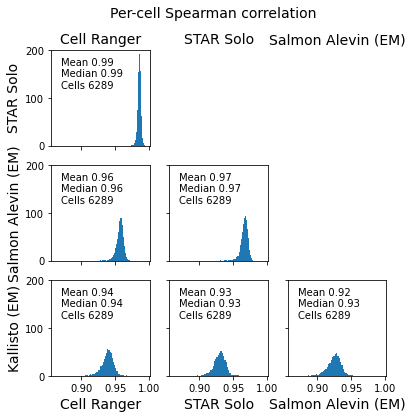

In [24]:
plot_cell_correlation_histogram(cor_1_1000, programs=plots)

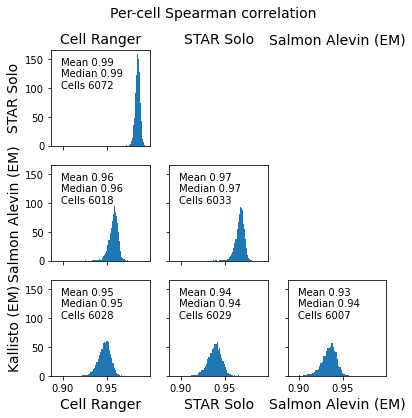

In [28]:
plot_cell_correlation_histogram(cor_2_1000, programs=plots)

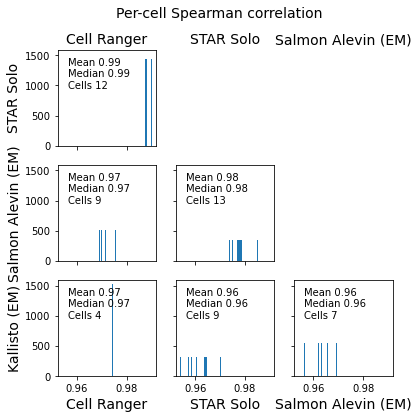

In [25]:
plot_cell_correlation_histogram(cor_10_1000, programs=plots)

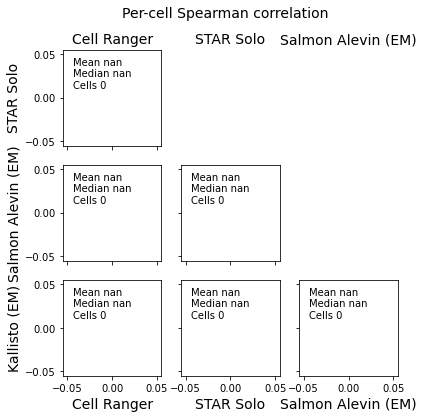

In [26]:
plot_cell_correlation_histogram(cor_100_1000, programs=plots)

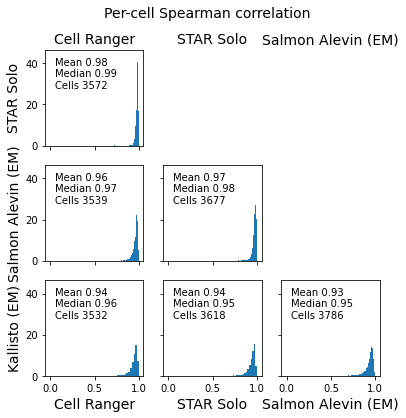

In [30]:
plot_cell_correlation_histogram(cor_100_10, programs=plots)